In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from braindecode.datasets.tuh import TUHAbnormal

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, 
    ChannelsSymmetryFB, predict_longitudinal_dataset,
    get_datasets, plot_age_gap_hist,
    plot_chronological_vs_predicted_age,
    plot_joint_scatter, save_fig,
)

In [2]:
exp = '220725141944002603'
base_dir = '/home/jovyan/full_runs/'
model = 'valid_best'  # 'train_end'

In [3]:
with open(os.path.join(base_dir, exp, f'checkpoint/{model}_model.pkl'), 'rb') as f:
    clf = pickle.load(f)
with open(os.path.join(base_dir, exp, 'data_scaler.pkl'), 'rb') as f:
    data_scaler = pickle.load(f)
with open(os.path.join(base_dir, exp, 'target_scaler.pkl'), 'rb') as f:
    target_scaler = pickle.load(f)
config = pd.read_csv(os.path.join(base_dir, exp, 'config.csv'), index_col=0).squeeze()

In [27]:
def plot_longitudinal_chronological_vs_predicted_age(base_dir, exp, subject_wise=True):
    fig, ax_arr = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 5))
    for i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
        df = pd.read_csv(os.path.join(base_dir, f'{exp}/preds/{longitudinal}.csv'), index_col=0)
        if subject_wise:
            df = df.groupby(['subject', 'pathological'], as_index=False).mean()
        
        ax = ax_arr[i]
        ax = plot_chronological_vs_predicted_age(df, ax=ax)
        ax.set_ylim(0, 100)
        ax.set_xlim(0, 100)
        ax.set_title(longitudinal)
        #save_fig(ax.get_figure(), out_dir, f'longitudinal-{longitudinal}_chronological_vs_predicted_age')

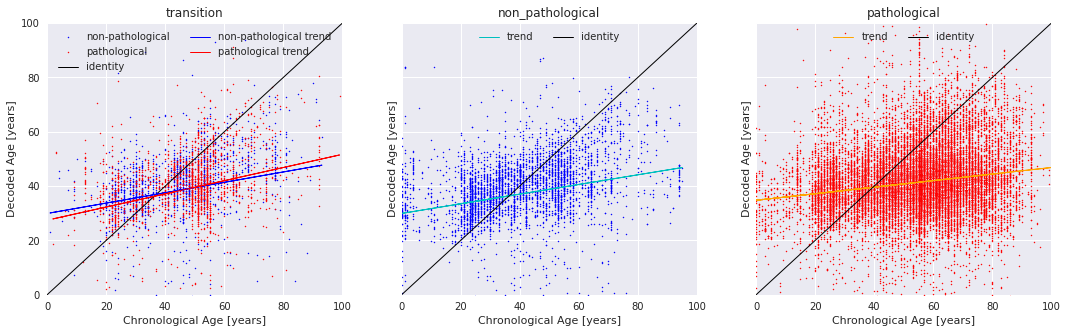

In [43]:
plot_longitudinal_chronological_vs_predicted_age(base_dir, exp, subject_wise=False)

In [24]:
def plot_longitudinal_age_gap_hist(base_dir, exp, subject_wise=True):
    fig, ax_arr = plt.subplots(3, 1, sharex=True, figsize=(18, 5))
    for i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
        df = pd.read_csv(os.path.join(base_dir, f'{exp}/preds/{longitudinal}.csv'), index_col=0)
        if subject_wise:
            df = df.groupby(['subject', 'pathological'], as_index=False).mean()
        
        ax = ax_arr[i]
        ax = plot_age_gap_hist(df, ax=ax)
        ax.set_title(longitudinal)
        #save_fig(ax.get_figure(), out_dir, f'longitudinal-{longitudinal}_age_gap_hist')

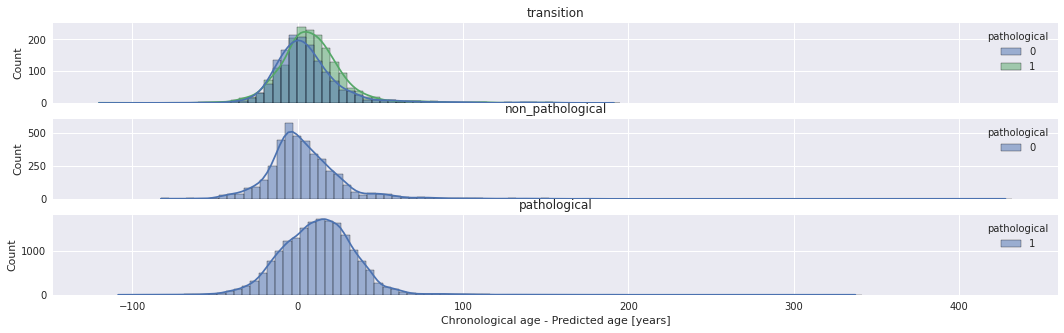

In [41]:
plot_longitudinal_age_gap_hist(base_dir, exp, subject_wise=False)

In [37]:
def plot_longitudinal_joint_scatter(base_dir, exp, subject_wise=True):
    for i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
        df = pd.read_csv(os.path.join(base_dir, f'{exp}/preds/{longitudinal}.csv'), index_col=0)
        if subject_wise:
            df = df.groupby(['subject', 'pathological'], as_index=False).mean()
        
        ax = plot_joint_scatter(df)
        ax.ax_joint.set_title(longitudinal)
        ax.ax_marg_x.axvline(df.y_pred[df.pathological==0].mean(), c='b')
        ax.ax_marg_x.axvline(df.y_pred[df.pathological==1].mean(), c='g')
        ax.ax_marg_y.axhline(df.y_true[df.pathological==0].mean(), c='b')
        ax.ax_marg_y.axhline(df.y_true[df.pathological==1].mean(), c='g')
        #save_fig(ax.fig, out_dir, f'longitudinal-{longitudinal}_jointplot')

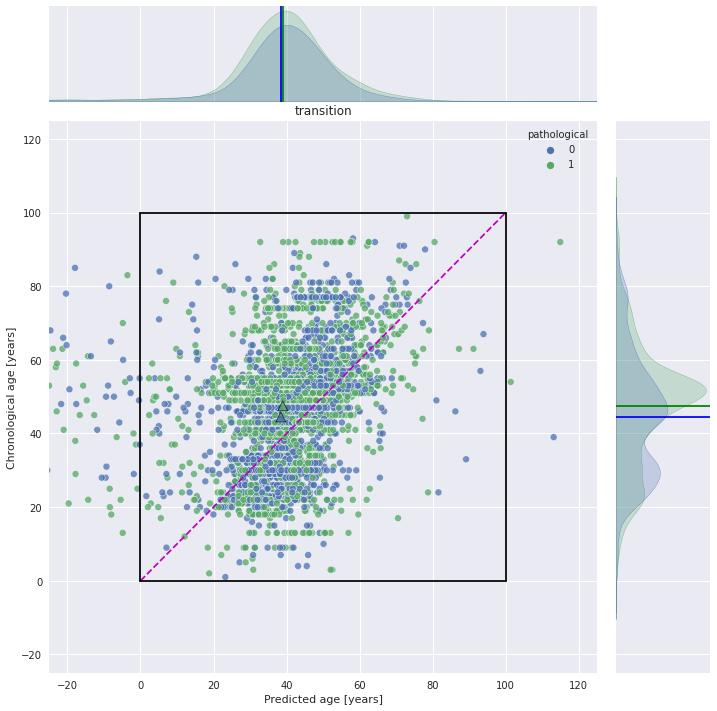

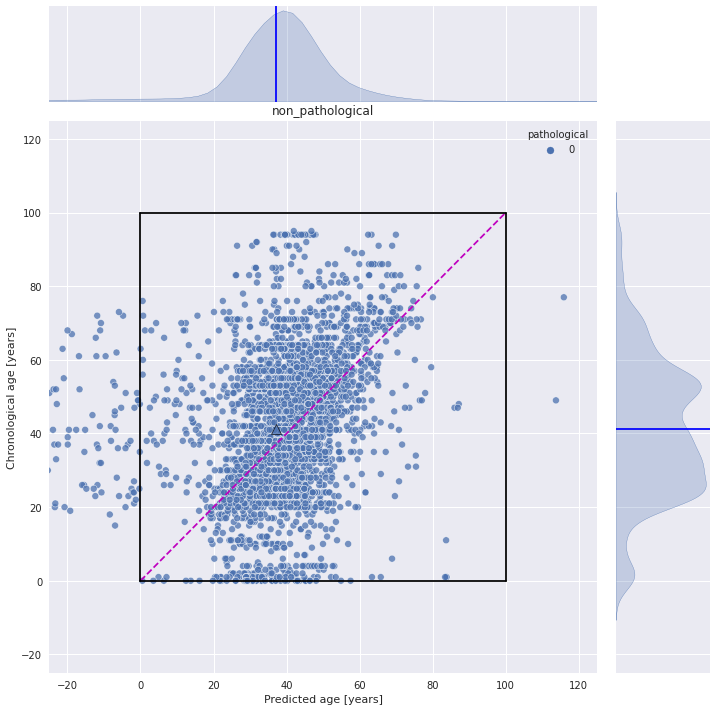

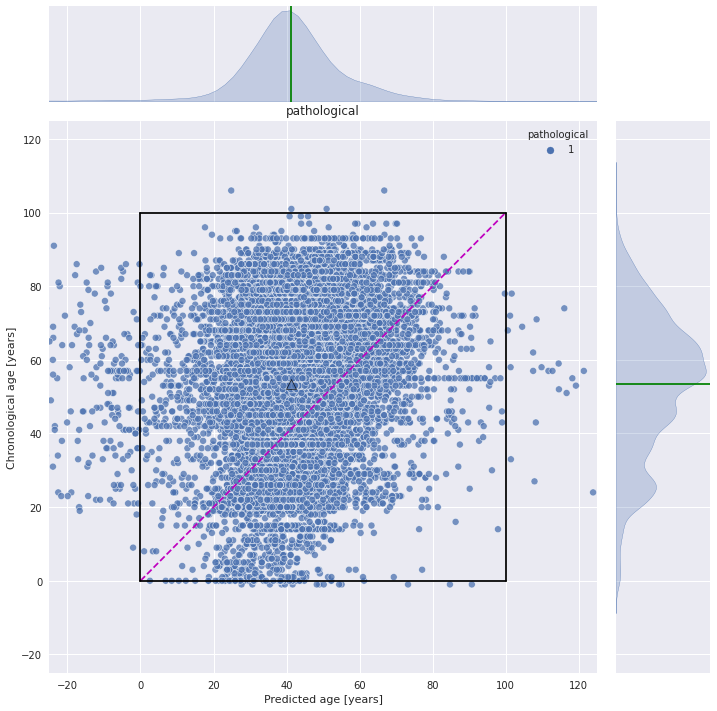

In [42]:
plot_longitudinal_joint_scatter(base_dir, exp, subject_wise=False)

In [6]:
df = pd.DataFrame(clf.history)

<AxesSubplot:>

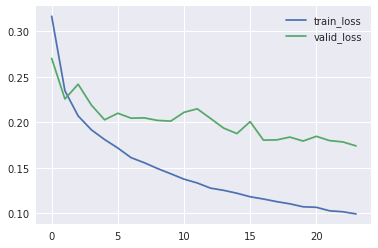

In [10]:
df.plot(y=['train_loss', 'valid_loss'])